In [1]:
## Import packages
import pandas as pd
import numpy as np
import plotly
from sqlalchemy import create_engine
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
engine = create_engine('sqlite:///%s' % '../data/coviddb')
df = pd.read_sql_table('CovidData', engine)

In [3]:
df.shape

(497, 34)

In [4]:
df.head()

,CityName,county_fips,state_id,density,ACCESS2,ARTHRITIS,BINGE,BPHIGH,BPMED,CANCER,...,MAMMOUSE,MHLTH,OBESITY,PAPTEST,PHLTH,SLEEP,STROKE,TEETHLOST,case1m,death1m
0,Abilene,48441,TX,441.0,0.2260,0.2430,0.1760,0.3110,0.6800,0.0590,...,0.7345,0.1320,0.3510,0.7780,0.1330,0.3355,0.0325,0.1565,2648.300808,40.370439
1,Akron,39153,OH,1233.0,0.1240,0.2895,0.1545,0.3640,0.7170,0.0605,...,0.7310,0.1555,0.3610,0.7955,0.1515,0.4315,0.0415,0.2155,1709.592780,207.080750
2,Alameda,6001,CA,2927.0,0.0750,0.1790,0.1785,0.2480,0.6300,0.0585,...,0.7790,0.0975,0.1830,0.8060,0.0905,0.3370,0.0220,0.0750,2110.346137,62.869091
3,Berkeley,6001,CA,4509.0,0.0740,0.1655,0.1920,0.2270,0.6100,0.0545,...,0.7985,0.1050,0.1955,0.8225,0.0860,0.3235,0.0210,0.0675,2110.346137,62.869091
4,Fremont,6001,CA,1171.0,0.0765,0.1515,0.1675,0.2285,0.6185,0.0500,...,0.7780,0.0845,0.1550,0.7915,0.0775,0.3430,0.0175,0.0675,2110.346137,62.869091


In [5]:
cm = df.corr()[['death1m']][2:-2]

In [6]:
import plotly.express as px
fig = px.bar(x=cm.index, y=cm)
fig.update_layout(xaxis_tickangle=-45,\
    title='Measure Correlations with death1m',\
        xaxis_title='Measure',\
            yaxis_title = 'Corr')
fig.show()

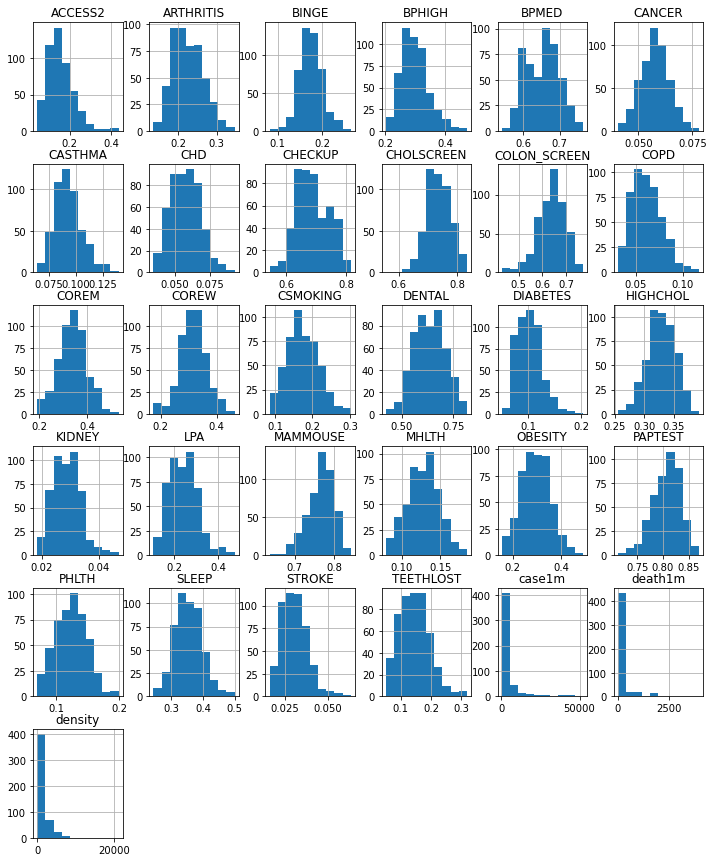

In [7]:
df.iloc[:,3:].hist(figsize = (12,15));

In [8]:
## Set X, y and split into train and test data set
X = df.drop(columns = ['county_fips','CityName','state_id','case1m', 'death1m','PAPTEST'])
y = df['death1m']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

In [9]:
##Train the model using OLS
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est = est.fit()
print(est.summary())

OLS Regression Results                            
Dep. Variable:                death1m   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     13.51
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           3.40e-39
Time:                        22:50:19   Log-Likelihood:                -2520.5
No. Observations:                 347   AIC:                             5099.
Df Residuals:                     318   BIC:                             5211.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3245.4204   1387.144     -2.340      0.020   -5974.559    -516

In [10]:
## Get significant variables
p = est.pvalues
significant_vars = p.loc[p < 0.10].index.tolist()
print('Population metrics related to covid death cases per 1M population: ', significant_vars)

Population metrics related to covid death cases per 1M population:  ['const', 'density', 'ACCESS2', 'ARTHRITIS', 'CANCER', 'CASTHMA', 'CHECKUP', 'COPD', 'COREM', 'DENTAL', 'DIABETES', 'HIGHCHOL', 'LPA']


In [11]:
## Predict on test data
r2 = r2_score(y_test, est.predict(sm.add_constant(X_test)))
print('r2-score on test data: ', round(r2,4))

r2-score on test data:  0.2011


In [12]:
## Load measures lookup
lookup = pd.read_sql_table('MeasureLookup', engine)

In [13]:
## Get measures summary
categories = lookup.groupby('Category').agg({'MeasureId': 'count'})
categories

,MeasureId
Category,
Health Outcomes,13
Prevention,10
Unhealthy Behaviors,5


In [14]:
pd.set_option('display.max_colwidth', None)
lookup.loc[lookup['MeasureId'].isin(significant_vars)][['MeasureId','Measure', 'Category']].sort_values(by = 'Category')

,MeasureId,Measure,Category
2,HIGHCHOL,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,Health Outcomes
7,ARTHRITIS,Arthritis among adults aged >=18 Years,Health Outcomes
8,CASTHMA,Current asthma among adults aged >=18 Years,Health Outcomes
9,DIABETES,Diagnosed diabetes among adults aged >=18 Years,Health Outcomes
17,CANCER,Cancer (excluding skin cancer) among adults aged >=18 Years,Health Outcomes
18,COPD,Chronic obstructive pulmonary disease among adults aged >=18 Years,Health Outcomes
10,ACCESS2,Current lack of health insurance among adults aged 18–64 Years,Prevention
21,DENTAL,Visits to dentist or dental clinic among adults aged >=18 Years,Prevention
23,CHECKUP,Visits to doctor for routine checkup within the past Year among adults aged >=18 Years,Prevention
27,COREM,"Older adult men aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening",Prevention
